Material properties: mu=384.615, kappa=833.333
Solving nonlinear problem...
Problem solved in 5 iterations
Tip node found at: (10.0000, 0.5000)
Tip displacement vector: (-0.010132, -0.135357)
Analytical solution: -0.136500
Numerical solution: -0.135357
Absolute error: 1.143158e-03
Relative error: 0.8375%


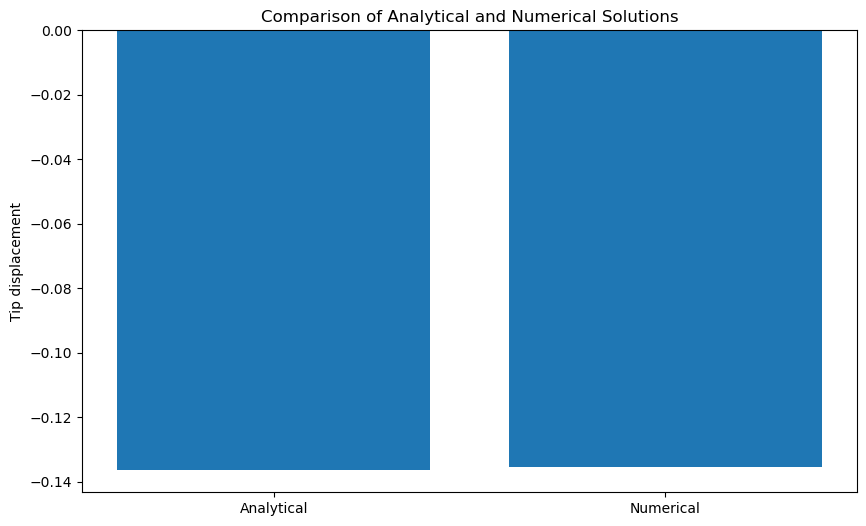

In [1]:
from dolfinx import mesh, fem, log, default_scalar_type
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import numpy as np
import ufl
import matplotlib.pyplot as plt
from mpi4py import MPI

# Beam geometry
L = 10.0   # length in x
H = 1.0    # height in y

# Material properties
E = 1000.0
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")

# Load (small load for validation)
q = -0.01  # load per unit length in y

# Mesh parameters
nx = 40    # number of elements along length
ny = 4     # number of elements along height

# Create 2D rectangular mesh
domain = mesh.create_rectangle(
    MPI.COMM_WORLD, 
    points=[[0.0, 0.0], [L, H]],
    n=[nx, ny],
    cell_type=mesh.CellType.triangle
)

# Define function space (using quadratic elements for better accuracy)
V = fem.functionspace(domain, ("Lagrange", 2, (domain.geometry.dim,)))

# Identify boundaries
def left_boundary(x): return np.isclose(x[0], 0.0)
def top_boundary(x): return np.isclose(x[1], H)

# Mark boundaries
fdim = domain.topology.dim - 1
left_facets = mesh.locate_entities_boundary(domain, fdim, left_boundary)
top_facets = mesh.locate_entities_boundary(domain, fdim, top_boundary)

# Create facet tags
marked_facets = np.hstack([left_facets, top_facets])
marked_values = np.hstack([
    np.full_like(left_facets, 1),  # left boundary = 1
    np.full_like(top_facets, 2)    # top boundary = 2
])
sorted_indices = np.argsort(marked_facets)
facet_tag = mesh.meshtags(
    domain, fdim, 
    marked_facets[sorted_indices], 
    marked_values[sorted_indices]
)

# Define fixed left boundary condition
u_bc = np.array((0, 0), dtype=default_scalar_type)
left_dofs = fem.locate_dofs_topological(V, fdim, facet_tag.find(1))
bcs = [fem.dirichletbc(u_bc, left_dofs, V)]

# Define solution and test functions
u = fem.Function(V, name="Displacement")
v = ufl.TestFunction(V)

# Neo-Hookean hyperelastic model
d = len(u)
I = ufl.variable(ufl.Identity(d))
F = ufl.variable(I + ufl.grad(u))      # Deformation gradient
C = ufl.variable(F.T * F)              # Right Cauchy-Green tensor
Ic = ufl.variable(ufl.tr(C))           # First invariant of C
J = ufl.variable(ufl.det(F))           # Volume ratio

# Stored energy density (Neo-Hookean)
psi = (mu / 2) * (Ic - d) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2

# First Piola-Kirchhoff stress tensor
P = ufl.diff(psi, F)

# Define distributed load on top edge
t = fem.Constant(domain, default_scalar_type((0, q)))

# Define measures for integration
dx = ufl.Measure("dx", domain=domain)
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)

# Variational form (internal - external forces)
F_internal = ufl.inner(P, ufl.grad(v)) * dx
F_external = ufl.inner(t, v) * ds(2)   # Applied on top edge (tag 2)
F_form = F_internal - F_external

# Set up nonlinear solver
problem = NonlinearProblem(F_form, u, bcs)
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-10
solver.atol = 1e-10
solver.max_it = 30

# Solve the problem
print("Solving nonlinear problem...")
num_its, converged = solver.solve(u)
assert converged, "Newton solver did not converge"
u.x.scatter_forward()
print(f"Problem solved in {num_its} iterations")

# Find the tip node (middle of right edge)
def find_closest_node(coords, target_x, target_y):
    distances = np.sqrt((coords[:, 0] - target_x)**2 + (coords[:, 1] - target_y)**2)
    return np.argmin(distances)

# Get coordinates of all nodes
coords = domain.geometry.x

# Find node closest to the middle of right edge
tip_node = find_closest_node(coords, L, H/2)
tip_coords = coords[tip_node]
print(f"Tip node found at: ({tip_coords[0]:.4f}, {tip_coords[1]:.4f})")

# Extract nodal displacement values
u_values = u.x.array.reshape(-1, 2)

# Get displacement at tip node
tip_disp = u_values[tip_node]
tip_disp_y = tip_disp[1]  # y-component
print(f"Tip displacement vector: ({tip_disp[0]:.6f}, {tip_disp[1]:.6f})")

# Calculate analytical solution for small displacement
E_eff = E / (1 - nu**2)  # Effective Young's modulus for plane stress
I = H**3 / 12.0         # Moment of inertia
w_analytical = q * L**4 / (8.0 * E_eff * I)

# Get numerical solution
w_numerical = tip_disp_y

# Calculate error
error = abs(w_numerical - w_analytical)
relative_error = error / abs(w_analytical) * 100

print(f"Analytical solution: {w_analytical:.6f}")
print(f"Numerical solution: {w_numerical:.6f}")
print(f"Absolute error: {error:.6e}")
print(f"Relative error: {relative_error:.4f}%")

# Plot results
plt.figure(figsize=(10, 6))
plt.bar(['Analytical', 'Numerical'], [w_analytical, w_numerical])
plt.ylabel("Tip displacement")
plt.title("Comparison of Analytical and Numerical Solutions")
#plt.savefig("validation_comparison.png")
plt.show()
